In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
from scipy.integrate import dblquad
from scipy.optimize import approx_fprime
from mpl_toolkits.mplot3d import Axes3D
from sympy import *

# import numdifftools as nd
# np.tensordot
# np.cross
# np.dot

# Just the cap

In [170]:
def vt(X: np.ndarray) -> np.ndarray:
    """Returns the tangent and azimutal unit vectors at point X on the unit sphere.
    Args:
        X (np.ndarray): A 3D point on the unit sphere.
        Returns:
        [-y/(x^2+y^2)^0.5, x/(x^2+y^2)^0.5, 0]"""
    # Assumes X is on the unit sphere
    return np.array([-X[1], X[0], 0])

def vr(X: np.ndarray) -> np.ndarray:
    """Returns the radial unit vector at point X on the unit sphere.
    Args:
        X (np.ndarray): A 3D point on the unit sphere.
        Returns:
        [X[0], X[1], X[2]]/(np.sqrt(X[0]**2 + X[1]**2 + X[2]**2))"""
    # Assumes X is on the unit sphere
    return np.array([X[0], X[1], X[2]])

def vn(X: np.ndarray) -> np.ndarray:
    """ Returns the unit vector towards north pole at point X on the unit sphere."""
    return np.cross(vr(X), vt(X))

def th(X: np.ndarray):
    """Returns the polar angle theta at point X on the unit sphere theta."""
    return np.arccos(X[2]/np.sqrt(X[0]**2 + X[1]**2 + X[2]**2))

def ncone(X: np.ndarray, w) -> np.ndarray:
    """Returns the director n on the boundary of the cone at point X on the unit sphere.
    Args:
        X (np.ndarray): A 3D point on the unit sphere.
        thetacone (float): The half-angle of the cone in radians.
        w (int): The winding number of the director along the boundary on the cone.
        Returns:
        n = cos(w*phi)*vt + sin(w*phi)*vr
        where phi = arctan2(y,x)
        
        if x=0 then we separate fo different cases"""
    if X[0] == 0 and X[1] == 0:
        return np.zeros(3)
    elif X[0] == 0 and X[1] > 0:   
        return np.cos(w * np.pi / 2) * vt(X) + np.sin(w * np.pi / 2) * vr(X)
    elif X[0] == 0 and X[1] < 0:
        return np.cos(w * np.pi / 2) * vt(X) - np.sin(w * np.pi / 2) * vr(X)        
    else:
        return np.cos(w * np.arctan2(X[1], X[0])) * vt(X) + np.sin(w * np.arctan2(X[1], X[0])) * vr(X)
    
def smectic_director(X):
    """ Returns the smectic director field at point X on the unit sphere. In north pole +Z direcrtion"""
    return np.cross(X, np.array([-X[1],X[0],0])) 

def nhat(X, thetacone: float, w=2, smectic_case = False, radial_case = False) -> np.ndarray:
    """Returns the director n at point X on the unit sphere.
    Args:
        X (np.ndarray): A 3D point on the unit sphere.
        thetacone (float): The half-angle of the cone in radians.
        w (int): The winding number of the director along the boundary on the cone.
        Returns:
        n = """
    if smectic_case:
        n = - th(X) * smectic_director(X) + (thetacone - th(X)) * np.array([0, 0, 1])
        # n = np.cos(th(X) * np.pi/(2 * thetacone)) * vr(X) + np.sin(th(X) * np.pi/(2 * thetacone)) * smectic_director(X)
    elif radial_case:
        n = np.sin(4 * th(X)) * X + np.cos(4 * th(X)) * X
    else:
        n = th(X) * ncone(X, w) + (thetacone - th(X)) * np.array([0, 0, 1]) # added a smooth term that vanishes at the boundary (thetacone)
    return n / np.linalg.norm(n)
    
def spherical_to_cartesian(theta, phi, r=1.0):
    """Convert spherical coordinates to Cartesian"""
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)  
    z = r * np.cos(theta)
    return np.array([x, y, z])

In [105]:
nhat(spherical_to_cartesian(np.pi/2, np.pi/4), thetacone=np.pi/3, w=2)


array([ 0.67082039,  0.67082039, -0.31622777])

In [4]:
x = symbols('x')
y = symbols('y')
z = symbols('z')

X = np.array([x,y,z])

np.cross(X, np.array([-X[1],X[0],0]))

array([-x*z, -y*z, x**2 + y**2], dtype=object)

In [5]:
def epsilon3d():
    eps = np.zeros((3,3,3))
    eps[0,1,2]=eps[1,2,0]=eps[2,0,1]=1
    eps[0,2,1]=eps[1,0,2]=eps[2,1,0]=-1
    return eps

In [6]:
def integrand(point, thetacone, winding, smectic_case=False) -> float:
    """epsilon_ijk epsilon_pqr n_q,i n_r,k n_p at point on the unit sphere.
    Args:
        point (np.ndarray): A 3D point on the unit sphere.
        thetacone (float): The half-angle of the cone in radians.
        winding (int): The winding number of the director along the boundary on the cone.
        Returns:
        A scalar representing the integrand at the given point."""

    
    grad_nx = approx_fprime(point, lambda p: nhat(p, thetacone, winding, smectic_case)[0])  # x-component - 3d vector
    grad_ny = approx_fprime(point, lambda p: nhat(p, thetacone, winding, smectic_case)[1])  # y-component - 3d vector
    grad_nz = approx_fprime(point, lambda p: nhat(p, thetacone, winding, smectic_case)[2])  # z-component - 3d vector
    n = nhat(point, thetacone, winding, smectic_case)  # 3d vector

    dn = np.stack((grad_nx, grad_ny, grad_nz), axis=0)  # 3x3 matrix
    r = np.array([point[0], point[1], point[2]])
    # print(dn)
    return np.round(0.5 * np.einsum('ijk,pqr,qj,rk,p,i', epsilon3d(), epsilon3d(), dn, dn, n, r) * th(point), decimals=8) # scalar: epsilon_ijk epsilon_pqr n_q,i n_r,k n_p, 0.5 because the einsum doubles it

In [7]:
def integrand_nematic(point) -> float:
    """epsilon_ijk epsilon_pqr n_q,i n_r,k n_p at point on the unit sphere.
    Args:
        point (np.ndarray): A 3D point on the unit sphere.
        Returns:
        A scalar representing the integrand at the given point."""
    
    x = smectic_director(point)[0]
    y = smectic_director(point)[1]
    z = smectic_director(point)[2]

    grad_nx = np.array([-z,0,-x])
    grad_ny = np.array([0, -z, -y])  # y-component - 3d vector
    grad_nz = np.array([2*x , 2*y, 0])  # z-component - 3d vector
    n = np.array([x, y, z])  # 3d vector
    
    dn = np.stack((grad_nx, grad_ny, grad_nz), axis=0)  # 3x3 matrix
    r = np.array([point[0], point[1], point[2]])
    # print(dn)
    return np.round(0.5 * np.einsum('ijk,pqr,qj,rk,p,i', epsilon3d(), epsilon3d(), dn, dn, n, r) * th(point), decimals=8) # scalar: epsilon_ijk epsilon_pqr n_q,i n_r,k n_p, 0.5 because the einsum doubles it

In [130]:
# Implementation: Convert your integrand to spherical coordinates

def integrand_spherical(theta, phi, thetacone=np.pi/2, winding=1, smectic_case=False, radial_case=False):
    """
    Your integrand function adapted for spherical coordinates
    
    This function:
    1. Converts (θ,φ) to Cartesian point on unit sphere
    2. Calls your existing integrand function
    3. Returns scalar value ready for integration
    """
    # Convert to Cartesian coordinates
    point_cartesian = spherical_to_cartesian(theta, phi)
    
    # Call your existing integrand function
    result = integrand(point_cartesian, thetacone, winding, smectic_case)

        
    
    return result

# integrand_spherical(theta=np.pi/3, phi=0, thetacone=np.pi/4, winding=3)


In [129]:
# Using scipy.integrate.dblquad 

def charge(thetacone = np.pi/2, winding=2, smectic_case=False, radial_case=False):
    """
    Compute surface integral using scipy.integrate.dblquad
    
    ∫∫_sphere integrand(θ,φ) sin(θ) dθ dφ
    """
    
    def integrand_with_jacobian(theta, phi):
        """Include the sin(θ) Jacobian factor"""
        return integrand_spherical(theta, phi, thetacone, winding, smectic_case, radial_case) * np.sin(theta) # If smectic_case is True, no need to pass winding, because it is simple smectic case
            
    
    # Integrate over the cap: θ ∈ [0,angle], φ ∈ [0,2π]
    result, error = dblquad(
        integrand_with_jacobian,
        0, 2*np.pi,          # φ limits
        lambda phi: 0,       # θ lower bound (constant)
        lambda phi: thetacone   # θ upper bound (constant)
        )

    return np.round(result / (4 * np.pi),2), np.round(error / (4 * np.pi), 2)

ratio_angle = lambda th: (1-np.round(np.cos(th),2))/2 # ratio of the angular area of the spherical cap to the angular area of the sphere

def charge_analytic(thetacone=np.pi/2, winding=2):
    """Analytic calculation of the charge for comparison = sum(s_i(1-b_i/2)) = - winding /2 + (1 - winding/2) = 1 - winding"""
    result = 1 - winding
    return result * ratio_angle(thetacone)


In [172]:
radial_result = charge(thetacone=np.pi/2, radial_case=True)[0]
radial_result

-0.5

In [124]:
result, error = charge(thetacone=np.pi/2,winding=0)
result

-0.52

In [15]:
analytic_result = charge_analytic(thetacone=np.pi/3,winding=3)
analytic_result

-0.5

In [91]:
qup = charge(thetacone=np.pi/2,smectic_case=True)[0]
qup

0.95

In [ ]:
qdown = charge()

In [141]:
#visualization of the director field on the sphere
def plot_vector_field(thetacone=np.pi/4, winding=1, num_points=20, smectic_case=False, radial_case=False):
    """Plot the director field on a cap of the sphere."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a grid of points on the sphere
    theta = np.linspace(0, thetacone, num_points)
    phi = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    # Convert spherical to Cartesian coordinates for plotting
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    # Compute the director field at each point
    u = np.zeros_like(x)
    v = np.zeros_like(y)
    w = np.zeros_like(z)
    
    for i in range(num_points):
        for j in range(num_points):
            point = np.array([x[i,j], y[i,j], z[i,j]])
            n = nhat(point, thetacone, winding, smectic_case,radial_case)
    
            u[i,j], v[i,j], w[i,j] = n
    
    # Plot the sphere surface
    # ax.plot_surface(x, y, z, color='c', alpha=0.3, rstride=1, cstride=1)
    
    # # Plot the vector field
    # ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)
    # set color and transperency of the arrows
    ax.set_alpha(1)
    ax.set_facecolor('none')
    #add diferent view angles
    ax.view_init(elev=20, azim=50)
    # show less arrows for clarity
    # ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True, arrow_length_ratio=0.1)
    #even less arrows
    # ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True, arrow_length_ratio=0.2)
    #make the arrows thinner and change color
    ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True, arrow_length_ratio=0.2, linewidth=0.5)
    #zoom in
    # ax.set_xlim([-1, 1])
    # ax.set_ylim([-1, 1])
    # ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(rf'Director Field ($\theta cone$ = {np.round(thetacone/np.pi, 2)}$\pi$, winding={winding})')
    plt.show()

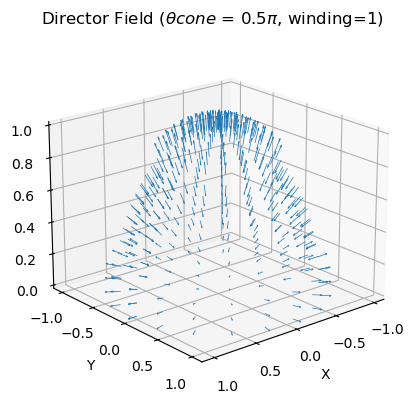

In [171]:
plot_vector_field(thetacone=np.pi/2, radial_case=True)

# Region with a hole

In [80]:
def nhat_for_hole(X, thetaup, thetadown, wup, wdown, smectic_case=False) -> np.ndarray:
    """Returns the director n at point X on the unit sphere for a hole.
    Args:
        X (np.ndarray): A 3D point on the unit sphere.
        thetaup (float): The upper half-angle of the cone in radians.
        thetadown (float): The lower half-angle of the cone in radians.
        wup (int): The winding number of the director along the boundary on the upper cone.
        wdown (int): The winding number of the director along the boundary on the lower cone.
        Returns:
        n = (th(X)- thetadown) * ncone(X, wup) + (thetaup - th(X)) * ncone(X, wdown)
        """
    if smectic_case:
        n = -(th(X) - thetadown) * (th(X) - np.mean([thetaup,thetadown])) * smectic_director(X) + (th(X) - thetaup) * (th(X) - np.mean([thetaup,thetadown]))  * smectic_director(X) + (th(X) - thetadown) * (thetaup - th(X)) * vr(X) 
        #  
        # 
    else:
        n = (th(X)- thetadown) * ncone(X, wup) + (thetaup - th(X)) * ncone(X, wdown)
    return n / np.linalg.norm(n)

In [40]:
nhat_for_hole(spherical_to_cartesian(np.pi/3, np.pi/4), np.pi/4, np.pi/2, 1, 3, smectic_case=True)

array([ 0.35355339,  0.35355339, -0.8660254 ])

In [20]:

def integrand_for_hole(point, thetaup, thetadown, wup, wdown,smectic_case=False) -> np.ndarray:
    """epsilon_ijk epsilon_pqr n_q,i n_r,k n_p at point on the unit sphere for a hole.
    Args:
        point (np.ndarray): A 3D point on the unit sphere.
        thetaup (float): The upper half-angle of the cone in radians.
        thetadown (float): The lower half-angle of the cone in radians.
        wup (int): The winding number of the director along the boundary on the upper cone.
        wdown (int): The winding number of the director along the boundary on the lower cone.
        Returns:
        A scalar representing the integrand at the given point."""
    grad_nx = approx_fprime(point, lambda p: nhat_for_hole(p, thetaup, thetadown, wup, wdown,smectic_case)[0], epsilon=1e-8)  # x-component - 3d vector
    grad_ny = approx_fprime(point, lambda p: nhat_for_hole(p, thetaup, thetadown, wup, wdown,smectic_case)[1], epsilon=1e-8)  # y-component - 3d vector
    grad_nz = approx_fprime(point, lambda p: nhat_for_hole(p, thetaup, thetadown, wup, wdown,smectic_case)[2], epsilon=1e-8)  # z-component - 3d vector
    n = nhat_for_hole(point, thetaup, thetadown, wup, wdown,smectic_case)  # 3d vector
    dn = np.stack((grad_nx, grad_ny, grad_nz), axis=0)  # 3x3 matrix
    r = np.array([point[0], point[1], point[2]])
    res = 0.5 * np.einsum('ijk,pqr,qj,rk,p,i', epsilon3d(), epsilon3d(), dn, dn, n, r)
    # print(dn)
    return res # scalar: epsilon_ijk epsilon_pqr n_q,i n_r,k n_p, the 0.5 is because the einsum counts each term twice

integrand_for_hole(spherical_to_cartesian(theta=np.pi/3, phi=0), np.pi/4, np.pi/8, 3, 1)

0.0

In [21]:
def integrand_spherical_for_hole(theta, phi, thetaup=np.pi/4, thetadown=np.pi/2, wup=0, wdown=0,smectic_case=False):
    """
    Your integrand function adapted for spherical coordinates for a hole
    
    This function:
    1. Converts (θ,φ) to Cartesian point on unit sphere
    2. Calls your existing integrand function for a hole
    3. Returns scalar value ready for integration
    """
    # Convert to Cartesian coordinates
    point_cartesian = spherical_to_cartesian(theta, phi)
    
    # Call your existing integrand function for a hole
    result = integrand_for_hole(point_cartesian, thetaup, thetadown, wup, wdown,smectic_case)

    return result

integrand_spherical_for_hole(theta=np.pi/3, phi=0, thetaup=np.pi/4, thetadown=np.pi/8, wup=3, wdown=1)

0.0

In [22]:
def charge_for_hole(thetaup=np.pi/4, thetadown=np.pi/2, wup=0, wdown=0,smectic_case=False):
    """
    Compute surface integral using scipy.integrate.dblquad for a hole
    
    ∫∫_sphere integrand(θ,φ) sin(θ) dθ dφ
    """
    
    def integrand_with_jacobian(theta, phi):
        """Include the sin(θ) Jacobian factor"""
        res = integrand_spherical_for_hole(theta, phi, thetaup, thetadown, wup, wdown,smectic_case) * np.sin(theta)
        # print(f"theta: {theta}, phi: {phi}, integrand: {res}")
        return res
        # return integrand_spherical_for_hole(theta, phi, thetaup, thetadown, wup, wdown) * np.sin(theta) --- IGNORE ---
    
    """ Integrate over the hole region: θ ∈ [θup,θdown], φ ∈ [0,2π] """
    result, error = dblquad(
        integrand_with_jacobian,
        0, 2*np.pi,              # φ limits
        lambda phi: thetaup,     # θ lower bound (constant) - its the upper theta of the cone 
        lambda phi: thetadown    # θ upper bound (constant) - its the lower theta of the cone
    )
    
    return result / (4 * np.pi), np.round(error / (4 * np.pi), 6)

In [96]:
smecticmiddle = charge_for_hole(thetaup=np.pi/3,thetadown=2*np.pi/3,smectic_case=True)[0]
smecticmiddle

-0.8660254054000757

In [94]:
smectic_up = charge(thetacone=np.pi/3,smectic_case=True)[0]
smectic_up

0.67

In [98]:
2* smectic_up - smecticmiddle

2.2060254054000756

In [59]:
smectic_down = charge(thetacone=np.pi/2,smectic_case=True)[0]
smectic_down

-0.02

In [62]:
np.round(smecticmiddle+smectic_up+smectic_down,2)

0.91

In [75]:
def plot_hole_vector_field(wup=1, wdown=3, thetaup=np.pi/4, thetadown=np.pi/2, smectic_case=False):
    """
    Plot the vector field nhat on the hole region
    """
    
    # Generate grid points on the sphere for the hole region
    theta = np.linspace(thetaup, thetadown, 20)
    phi = np.linspace(3*np.pi/2, 2 * np.pi, 5)
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    # Convert spherical to cartesian coordinates
    X = np.sin(theta_grid) * np.cos(phi_grid)
    Y = np.sin(theta_grid) * np.sin(phi_grid)
    Z = np.cos(theta_grid)

    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    W = np.zeros_like(Z)

    # Compute director field at each point
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pt = np.array([X[i, j], Y[i, j], Z[i, j]])
            n = nhat_for_hole(pt, thetaup, thetadown, wup, wdown,smectic_case)
            U[i, j], V[i, j], W[i, j] = n

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot director field
    ax.quiver(X, Y, Z, U, V, W, length=0.1, normalize=True, label='Director field')
    
    # Compute and plot perpendicular vector field
    U_perp = np.zeros_like(U)
    V_perp = np.zeros_like(V)
    W_perp = np.zeros_like(W)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            n_vec = np.array([U[i, j], V[i, j], W[i, j]])
            r_vec = np.array([X[i, j], Y[i, j], Z[i, j]])
            perp = np.cross(n_vec, r_vec)
            if np.linalg.norm(perp) > 0:
                perp = perp / np.linalg.norm(perp)
            U_perp[i, j], V_perp[i, j], W_perp[i, j] = perp

    # Shift perpendicular vectors to midpoint
    mid_X = X + 0.5 * U * 0.1
    mid_Y = Y + 0.5 * V * 0.1
    mid_Z = Z + 0.5 * W * 0.1

    # ax.quiver(mid_X, mid_Y, mid_Z, U_perp, V_perp, W_perp, 
    #           length=0.1, normalize=True, color='orange', label='Perpendicular field')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if smectic_case:
        ax.set_title(rf'Smectic vector field on hole region ($\theta_{{up}}$={thetaup/np.pi} $\pi$, $\theta_{{down}}$={thetadown/np.pi:.2f} $\pi$)')
    else:
        ax.set_title(rf'Vector field on hole region ($w_{{up}}$={wup}, $w_{{down}}$={wdown})')
    ax.legend()
    
    ax.view_init(elev=0, azim=60)

    plt.tight_layout()
    plt.show()

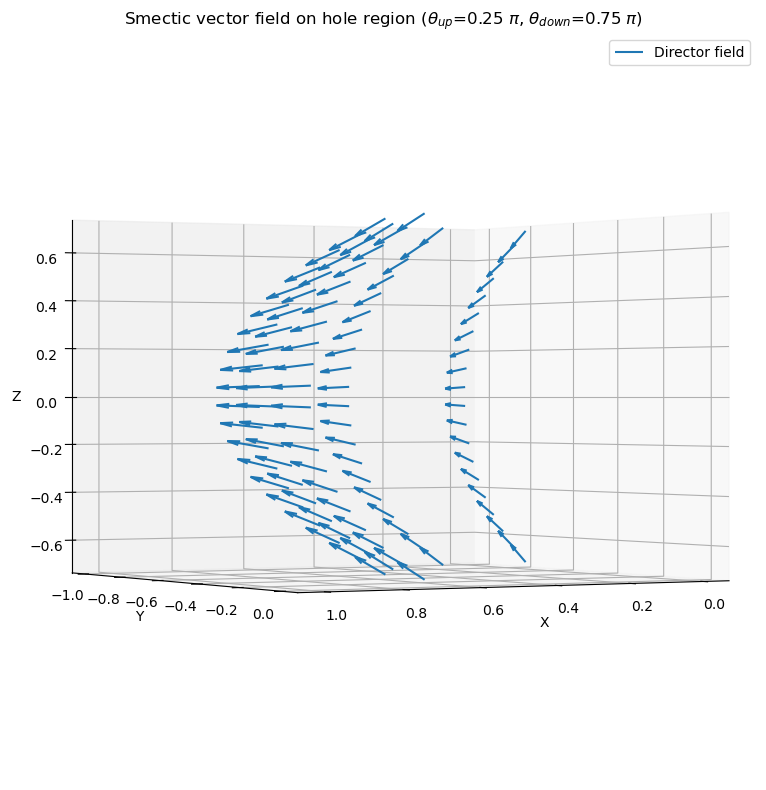

In [81]:
plot_hole_vector_field(thetaup=np.pi/4, thetadown= 3*np.pi/4, smectic_case=True)

In [ ]:
def integrand_radial_field(point):    
    
    grad_nx = approx_fprime(point, lambda p: vr(p)[0], epsilon=1e-8)  # x-component - 3d vector
    grad_ny = approx_fprime(point, lambda p: vr(p)[1], epsilon=1e-8)  # y-component - 3d vector
    grad_nz = approx_fprime(point, lambda p: vr(p)[2], epsilon=1e-8)  # z-component - 3d vector
    n = vr(point)  # 3d vector
    dn = np.stack((grad_nx, grad_ny, grad_nz), axis=0)  # 3x3 matrix
    r = np.array([point[0], point[1], point[2]])
    res = 0.5 * np.einsum('ijk,pqr,qj,rk,p,i', epsilon3d(), epsilon3d(), dn, dn, n, r)
    # print(dn)
    return res # scalar: epsilon_ijk epsilon_pqr n_q,i n_r,k n_p, the 0.5 is because the einsum counts each term twice

def integrand_spherical_radial_field(theta, phi):
    """
    Your integrand function adapted for spherical coordinates for a radial field
    
    This function:
    1. Converts (θ,φ) to Cartesian point on unit sphere
    2. Calls your existing integrand function for a radial field
    3. Returns scalar value ready for integration
    """
    # Convert to Cartesian coordinates
    point_cartesian = spherical_to_cartesian(theta, phi)
    
    # Call your existing integrand function for a radial field
    result = integrand_radial_field(point_cartesian)

    return result

def charge_radial_field(thetaup, thetadown):
    """
    Compute surface integral using scipy.integrate.dblquad for a radial field
    
    ∫∫_sphere integrand(θ,φ) sin(θ) dθ dφ
    """
    
    def integrand_with_jacobian(theta, phi):
        """Include the sin(θ) Jacobian factor"""
        res = integrand_spherical_radial_field(theta, phi) * np.sin(theta)
        # print(f"theta: {theta}, phi: {phi}, integrand: {res}")
        return res
    
    """ Integrate over the full sphere: θ ∈ [0,π], φ ∈ [0,2π] """
    result, error = dblquad(
        integrand_with_jacobian,
        0, 2*np.pi,              # φ limits
        lambda phi: thetaup,           # θ lower bound (constant)
        lambda phi: thetadown        # θ upper bound (constant)
    )
    
    return np.round(result / (4 * np.pi),6), np.round(error / (4 * np.pi), 6)

In [ ]:
ch1 = charge(np.pi/2,2)[0]

In [ ]:
ch2 = charge_radial_field(np.pi/5, np.pi/2)[0]

In [ ]:
ch3 = charge(np.pi/2, 4)[0]

In [ ]:
np.round(ch1,2)-np.round(ch2,2)+np.round(ch3,2)

-2.21

In [ ]:
ch1-ch2+ch3

-2.218242226487207

In [ ]:
ch4 = charge_for_hole(thetaup=np.pi/5,thetadown=np.pi/2,wup=3, wdown=4)[0]

In [ ]:
ch1-  ch4+  ch3

-1.8137342275713912

In [ ]:
smecticmiddle + charge(thetacone=np.pi/4,smectic_case=True)[0] * 2

0.8671067805192586